In [4]:
import torch
from torchvision import transforms
from PIL import Image

# Load the pretrained model
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
patch_size = dinov2_vits14.patch_size

# Preprocess the image
imagePath = './darts/Screenshot_2.png'
image = Image.open(imagePath).convert('RGB')
width, height = image.size
aspect_ratio = width / height

transform = transforms.Compose([           
                                transforms.Resize((int(800 / aspect_ratio), 800)),         
                                transforms.ToTensor(),                    
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

img = transform(image)
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)



total_features  = []
attentions = []
# Generate the attention mask
with torch.no_grad():
    features_dict = dinov2_vits14.forward_features(img)
    features = features_dict['x_norm_patchtokens']
    attentions = features
    total_features.append(features)
    
total_features = torch.cat(total_features, dim=0)
total_features.shape

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


torch.Size([1, 5586, 384])

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
 # patchsize=14

#520//14
patch_h  = img.shape[-2]//patch_size
patch_w  = img.shape[-1]//patch_size
print(patch_h)
print(patch_w)
print(img.shape[-2])
print(img.shape[-1])

# feat_dim = 1024 # vitl14
feat_dim = 384 # vits14

print(total_features)
print(total_features.shape)
total_features = total_features.reshape(1 * patch_h * patch_w, feat_dim) #4(*H*w, 1024)
print(total_features.shape)

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)
print(pca_features.shape)

98
57
1372
798
tensor([[[-1.6938e+00, -4.7488e+00, -1.1134e+00,  ...,  8.2274e-01,
           8.9804e-01, -1.0826e-01],
         [-1.4783e+00, -6.1517e+00, -1.3474e+00,  ...,  1.0757e+00,
           4.3153e-01, -5.6363e-01],
         [-1.3312e+00, -7.1013e+00, -1.4287e+00,  ...,  8.4956e-01,
          -2.9870e-03, -6.8278e-01],
         ...,
         [-7.4545e-02, -2.1206e+00, -1.2585e+00,  ...,  1.3475e+00,
          -2.1970e-02, -8.5953e+00],
         [-6.6169e-01, -2.6969e+00, -7.3905e-02,  ...,  1.7927e+00,
          -1.7017e-01, -8.9399e+00],
         [-1.7164e+00, -2.4191e+00,  7.9603e-01,  ..., -1.8960e+00,
          -9.6836e-01, -5.2822e+00]]])
torch.Size([1, 5586, 384])
torch.Size([5586, 384])
(5586, 3)


[[ 0.          1.67308801  0.        ]
 [ 0.          1.88859123  0.        ]
 [ 0.          2.64427787  0.        ]
 ...
 [ 0.          0.         20.64016253]
 [ 3.10221688  0.         23.00473295]
 [ 8.93762215  0.         24.09731103]]
(5586, 3)
(98, 57)


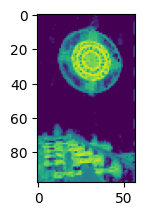

In [6]:
for i in pca_features:
        i[i < 0.5] = 0

print(pca_features)
print(pca_features.shape)
attention_mask = pca_features[0 : patch_h*patch_w, 0].reshape(patch_h, patch_w)
for i in range(1):
    plt.subplot(2, 2, i+1)
    print(attention_mask.shape)
    plt.imshow(attention_mask)

plt.show()
plt.imsave(fname="darts/result.png", arr=attention_mask, format='png')

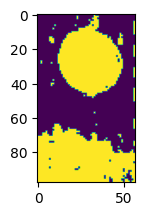

In [7]:
pca_features_bg = pca_features[:, 0] > 0.35 # from first histogram
pca_features_fg = ~pca_features_bg

attention_mask = pca_features_bg[0: patch_h * patch_w].reshape(patch_h, patch_w)
# plot the pca_features_bg
for i in range(1):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()
# plt.imsave(fname="darts/result.png", arr=attention_mask, format='png')

In [8]:
def get_normalized_size(center_of_mass, image_width, image_height):
    # print(center_of_mass, image_width, image_height)
    normalized_width = (center_of_mass[0] / (image_width / 100)) / 100
    normalized_height = (center_of_mass[1] / (image_height / 100)) / 100
    return normalized_width, normalized_height

image_width = patch_w
image_height = patch_h

In [16]:
import cv2
import numpy as np

img = cv2.imread("darts/result.png", 0)
img = cv2.GaussianBlur(img, (5, 5), 0)

# Apply Hough Circle Transform
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=35, minRadius=15, maxRadius=0)
print(circles)

# Convert the (x, y) coordinates and radius of the circles to integers
circles = np.round(circles[0, :]).astype("int")
print(circles)

coordinates = None
radius = None
# Draw circles on the original image
for (x, y, r) in circles:
    coordinates = get_normalized_size((x,y),image_width, image_height)
    radius = r
    print(x, y, r)
    cv2.circle(img, (x, y), r, (0, 255, 0), 2)


cv2.imwrite("darts/result2.png", img)
print(coordinates)

print(width)
print(image_width)

print(height)
print(image_height)

radius =int( radius * (((width/image_width) + (height/image_height))/2))
delimeter =radius * 2
print(f"delimeter: {delimeter}")

print(coordinates[0] *width, coordinates[1] *height)

[[[31.5 26.5 19.9]]]
[[32 26 20]]
32 26 20
(0.5614035087719299, 0.2653061224489796)
525
57
907
98
delimeter: 368
294.7368421052632 240.63265306122452


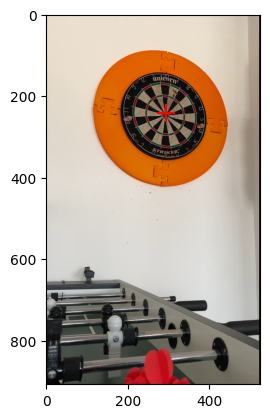

In [17]:
from matplotlib import image as mpimg
plt.imshow(mpimg.imread(imagePath))
plt.scatter(coordinates[0] *width, coordinates[1] *height, s=160, marker='+', color="red")
plt.show()

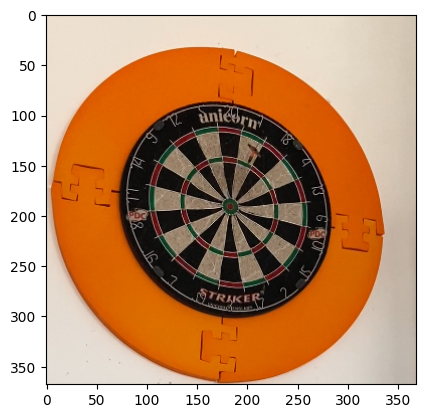

In [18]:
x = int(coordinates[0] *width)
y = int(coordinates[1] *height)
img = cv2.imread(imagePath)


crop_img = img[y-radius:y+radius, x-radius:x+radius]
cv2.imwrite("darts/result4.png", crop_img)

plt.imshow(mpimg.imread("darts/result4.png"))
plt.show()

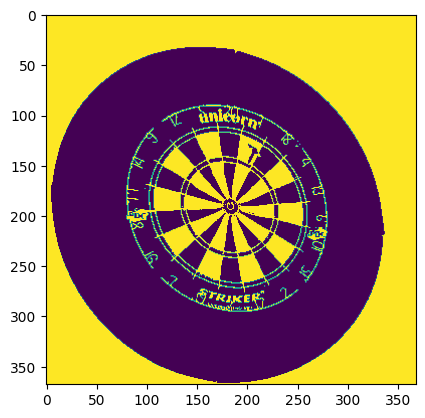

In [19]:
img = cv2.imread('darts/result4.png')
# Convert the image to the HSV color space
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define the lower and upper limits of the color range you want to track
lower_limit = np.array([0, 0, 65])  # Lower limit for black color
upper_limit = np.array([190, 130, 255])  # Upper limit for yellow color

mask = cv2.inRange(hsv, lower_limit, upper_limit)

plt.imshow(mask)
plt.show()

plt.imsave(fname="darts/result5.png", arr=mask, format='png')

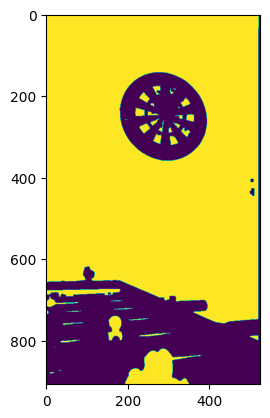

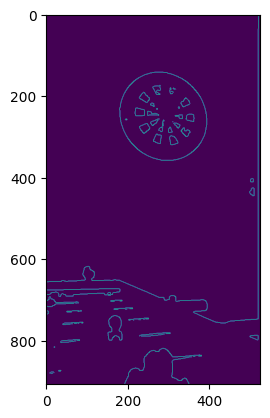

True

In [20]:
color = cv2.imread('Screenshot_2.png', cv2.IMREAD_COLOR)

imCalHSV = cv2.cvtColor(color, cv2.COLOR_BGR2HSV)
kernel = np.ones((5, 5), np.float32) / 25
blur = cv2.filter2D(imCalHSV, -1, kernel)
h, s, imCal = cv2.split(blur)

## threshold important -> make accessible
#ret, thresh = cv2.threshold(imCal, 140, 255, cv2.THRESH_BINARY_INV)
ret, thresh = cv2.threshold(imCal, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

## kernel size important -> make accessible
# very important -> removes lines outside the outer ellipse -> find ellipse
kernel = np.ones((5, 5), np.uint8)
thresh2 = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
plt.imshow(thresh2)
plt.show()

cv2.imwrite('filtered.png', thresh2)

def autocanny(imCal):
    # apply automatic Canny edge detection using the computed median
    sigma = 0.33
    v = np.median(imCal)
    #lower = int(max(0, (1.0 - sigma) * v))
    #upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(imCal, 250, 255)

    return edged
    
edges =autocanny(thresh2)
# Save the edge detected image
plt.imshow(edges)
plt.show()
cv2.imwrite('edges.png', edges)

287.41680908203125 250.4686737060547 57 98
287.423583984375 250.46922302246094 57 98
(0.3168948004237872, 0.477084234328497)
225


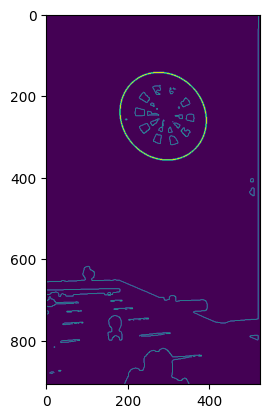

In [21]:
import cv2

img = cv2.imread("edges.png", 0)

contours, hierarchy = cv2.findContours(img, 1, 2)

minThresE = 10000
maxThresE = 1500000/4

ellipseWidth = 0
center_ellipse = None
elipse = None
## contourArea threshold important -> make accessible
for cnt in contours:
    if minThresE < cv2.contourArea(cnt) < maxThresE:
        ellipse = cv2.fitEllipse(cnt)
        cv2.ellipse(img, ellipse, (15, 15, 0), 2)

        x, y = ellipse[0]
        a, b = ellipse[1]
        angle = ellipse[2]
        print(x,y,image_width,image_height)

        center_ellipse = (x, y)

        coordinates = get_normalized_size((x,y),img.shape[0], img.shape[1])
        ellipseWidth = int(max(ellipse[1]))  # Width is the larger of the two axis lengths

        a = a / 2
        b = b / 2

        cv2.ellipse(img, (int(x), int(y)), (int(a), int(b)), int(angle), 0.0, 360.0,
                   (255, 255, 255), 2)

plt.imshow(img)
plt.show
cv2.imwrite("darts/result2.png", img)
print(coordinates)

print(ellipseWidth)
halfWidth = int(ellipseWidth/2)

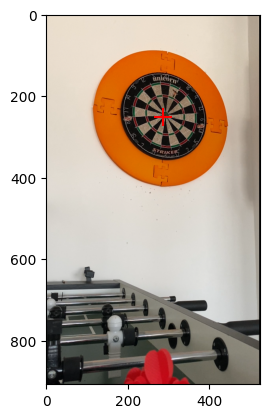

In [22]:
from matplotlib import image as mpimg
plt.imshow(mpimg.imread(imagePath))
plt.scatter(center_ellipse[0], center_ellipse[1], s=160, marker='+', color="red")
plt.show()

287 250 112


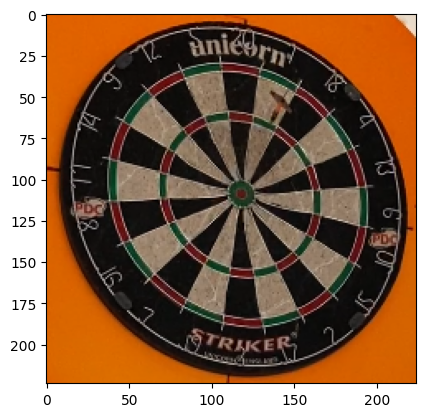

In [23]:
x = int(center_ellipse[0])
y = int(center_ellipse[1])
print(x,y, halfWidth)
img = cv2.imread("./darts/Screenshot_2.png")
crop_img = img[y-halfWidth:y+halfWidth, x-halfWidth:x+halfWidth]

cv2.imwrite("darts/result4.png", crop_img)

plt.imshow(mpimg.imread("darts/result4.png"))
plt.show()

[[[ 3.3000000e+01  2.1118484e+00]]

 [[-1.7000000e+01  2.4260077e+00]]

 [[ 1.6100000e+02  8.2030475e-01]]

 [[-5.5000000e+01  2.6703537e+00]]

 [[ 1.3200000e+02  1.3962634e-01]]

 [[-9.9000000e+01  2.9845130e+00]]]


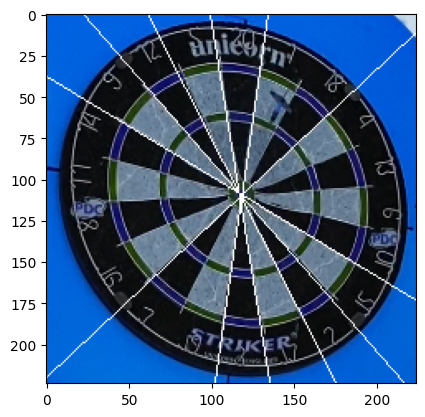

In [24]:
img = cv2.imread("./darts/result4.png")
edges =autocanny(img)
# Save the edge detected image
plt.imshow(edges)

lines = cv2.HoughLines(edges, 1, np.pi / 180, 90, 100)
print(lines)

## sector angles important -> make accessible
for line in lines:
# split between horizontal and vertical lines (take only lines in certain range)
    for rho, theta in line:
# split between horizontal and vertical lines (take only lines in certain range)
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 2000 * (-b))
        y1 = int(y0 + 2000 * (a))
        x2 = int(x0 - 2000 * (-b))
        y2 = int(y0 - 2000 * (a))
    
        cv2.line(img, (x1, y1), (x2, y2), (255, 255, 255), 1)

plt.imshow(img)
plt.show()


In [ ]:
img = cv2.imread("./darts/result4.png")
contours, hierarchy = cv2.findContours(edges, 1, 2)
minThresE = 100
maxThresE = 1500000/4
ellipse = None
## contourArea threshold important -> make accessible
for cnt in contours:
    if minThresE < cv2.contourArea(cnt) < maxThresE:
        ellipse = cv2.fitEllipse(cnt)
        
(center_x, center_y), (major_axis, minor_axis), angle = ellipse

# Calculate the destination points for a circle
circle_radius = (major_axis + minor_axis) / 2
circle_center = (center_x, center_y)
circle_points = cv2.circle(np.zeros_like(img), circle_center, int(circle_radius), (255, 255, 255), -1)
destination_points = np.argwhere(circle_points[:,:,0] == 255)

# Calculate the homography matrix
homography_matrix, _ = cv2.findHomography(cnt.squeeze(), destination_points)

warped_image = cv2.warpPerspective(img, homography_matrix, (img.shape[1], img.shape[0]))
plt.imshow(warped_image)
plt.show()

In [ ]:
ellipse_center = (x, y)  # Center coordinates of the ellipse
major_axis = a  # Major axis length
minor_axis = b  # Minor axis length
rotation_angle = theta  # Angle of rotation

# Calculate the scaling factor to turn the ellipse into a circle
scaling_factor = a / b

# Create an affine transformation matrix
M = cv2.getRotationMatrix2D(ellipse_center, -rotation_angle, scaling_factor)

# Apply the transformation to the original image
transformed_image = cv2.warpAffine(original_image, M, (width, height))